In [104]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from numpy import random
import inspect

In [105]:
def func_g(x):
    return -(np.sin(6*np.pi*x)**2) + 6*x**2 - 5*x**4 + 1.5

In [106]:
l = 30
vec = []
for i in range(1,31):
    xi = (i-1)/(l-1)
    vec.append(xi)
vec = np.array(vec)
finalgrid = np.meshgrid(vec, vec)
finalgrid

[array([[0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
         0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
         0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
         0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
         0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
         0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ],
        [0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
         0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
         0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
         0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
         0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
         0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ],
        [0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
         0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
         0.34482759, 0.37931034,

In [107]:
yi = func_g(vec) + np.random.normal(0,0.01,30)
n = len(yi)

In [108]:
train_indeces = random.choice(range(n), 20, replace=False)
test_indeces = np.setdiff1d(range(n), train_indeces)
x_train = vec[train_indeces]
y_train = yi[train_indeces]

x_test = vec[test_indeces]
test = yi[test_indeces]

In [109]:
def rbf_kernel(xa, xb):
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [110]:
K = rbf_kernel(train.reshape(-1, 1), train.reshape(-1, 1))

In [111]:
import tensorflow_probability as tfp
tfk = tfp.math.psd_kernels

def get_local_periodic_kernel(periodic_length_scale, period, amplitude, local_length_scale):
    periodic = tfk.ExpSinSquared(amplitude=amplitude, length_scale=periodic_length_scale, period=period)
    local = tfk.ExponentiatedQuadratic(length_scale=local_length_scale)
    return periodic * local

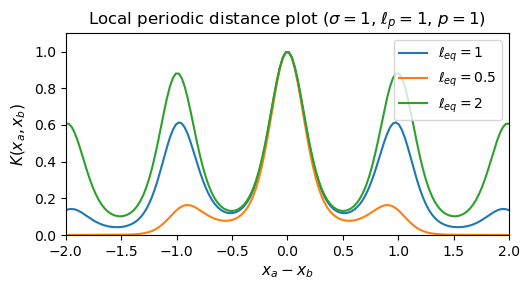

In [112]:
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=150), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3))
Σ = get_local_periodic_kernel(periodic_length_scale=1., period=1., amplitude=1., local_length_scale=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell_{eq}=1$')
Σ = get_local_periodic_kernel(periodic_length_scale=1, period=1, amplitude=1, local_length_scale=0.5).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell_{eq}=0.5$')
Σ = get_local_periodic_kernel(periodic_length_scale=1., period=1., amplitude=1., local_length_scale=2.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell_{eq}=2$')
ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Local periodic distance plot ($\\sigma=1$, $\\ell_p=1$, $p=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
plt.show()
#

In [141]:
def loc_per_kernel(x, xprime, sig2, p, lp, lse):
    """
    :param sig2: variance
    :param p: period
    :param lp: length parameter of periodic kernel
    :param lse: length parameter of squared exponential kernel 
    """
    
    periodic_kernel = sig2 * np.exp(- 2 * np.power(np.sin(np.pi*np.abs(x - xprime)/p), 2)/ np.power(lp, 2))
    squared_exponential_kernel = np.exp(-np.power(x-xprime, 2)/2*np.power(lse, 2))
    return periodic_kernel * squared_exponential_kernel

In [130]:
def negLogLikelihood(params, kernel, S=x_train, y=y_train):
    noise_y = params[0]    
    eta = params[1:]
    periodic_length_scale = eta[0] 
    period = eta[1]
    amplitude = eta[2]
    local_length_scale = eta[3]
    sigma_y_I = noise_y*np.eye(y.shape[0])
    if "eta" in inspect.signature(kernel).parameters.keys(): # NOTE: this check is not strictly required
        K = kernel(S[:, np.newaxis], S[:, np.newaxis], periodic_length_scale, period, amplitude, local_length_scale)
    else:
        K = kernel(S[:, np.newaxis], S[:, np.newaxis], periodic_length_scale, period, amplitude, local_length_scale)
    n = y.shape[0]
    # using lecture notes 6.2
    observed_fit = y.T@scipy.linalg.inv(sigma_y_I+K)@y
    model_complexity = np.log(np.linalg.det(sigma_y_I+K))
    print(f"data fit={np.round(observed_fit,2)}")
    print(f"model complexity={np.round(model_complexity,2)}")
    # print(f"reg. const.={np.round(n/2*np.log(np.sqrt(2*np.pi)),2)} [OMITTED]")
    ll = -1/2*observed_fit - 1/2*model_complexity #- n/2*np.log(np.sqrt(2*np.pi)) # NOTE: we can drop the constant here
    # small HACK to avoid -inf of problematic regions
    if np.isinf(ll):
        return np.inf # NOTE: we optimize by minimization, hence large positive value should be discarded by opt routine
    return -ll # NEGATIVE loglikelihood

In [131]:
def optimize_params(ranges, kernel, Ngrid):
    opt_params = scipy.optimize.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    eta = opt_params[1:]
    nll = negLogLikelihood(opt_params, kernel) # NOTE: added
    print(f"optimized NLL={nll}")
    return noise_var, eta

In [132]:
kernel = loc_per_kernel # todo: change to new kernel
ranges = ((1.e-5, 5), (1.e-5, 5), (1.e-5, 5), (1.e-5, 5) , (1.e-5, 5)) # todo: change to the new parameters
Ngrid = 4
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1292339.57
model complexity=-227.21
data fit=1

In [142]:
# B) todo: implement the posterior distribution, i.e. the distribution of f^star
def conditional(X, x_star, y, noise_var, kernel, eta):
    # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    periodic_length_scale = eta[0] 
    period = eta[1]
    amplitude = eta[2]
    local_length_scale = eta[3]
    
    sigma_I = noise_var*np.eye(y.shape[0])
    mu_star = kernel(X, x_star, periodic_length_scale, period, amplitude, local_length_scale).T @ scipy.linalg.inv( kernel(X, X, periodic_length_scale, period, amplitude, local_length_scale)+sigma_I) @ y
    sigma_star = kernel(x_star, x_star, periodic_length_scale, period, amplitude, local_length_scale) - kernel(X, x_star, periodic_length_scale, period, amplitude, local_length_scale).T @ scipy.linalg.inv( kernel(X,X, periodic_length_scale, period, amplitude, local_length_scale)+sigma_I ) @ kernel(X, x_star, periodic_length_scale, period, amplitude, local_length_scale)
    return mu_star, sigma_star # return mean and covariance matrix

In [143]:
pred_mu_gauss, pred_cov_gauss = conditional(x_train[:, np.newaxis], x_test[:, np.newaxis], y_train, noise_var, kernel, eta)

ValueError: operands could not be broadcast together with shapes (20,1) (10,1) 

In [139]:
x_test[:, np.newaxis]

array([[0.        ],
       [0.03448276],
       [0.06896552],
       [0.10344828],
       [0.27586207],
       [0.34482759],
       [0.37931034],
       [0.4137931 ],
       [0.5862069 ],
       [0.75862069]])

In [146]:
periodic_length_scale = eta[0] 
period = eta[1]
amplitude = eta[2]
local_length_scale = eta[3]
kernel(x_train[:, np.newaxis], x_test[:, np.newaxis], periodic_length_scale, period, amplitude, local_length_scale)

ValueError: operands could not be broadcast together with shapes (20,1) (10,1) 